# Visualizing Classification Structure

We demonstrate how to compute and visualize class similarities in MIT Places365 which contains 365 classes of scenes and places (http://places2.csail.mit.edu/).
We use a pre-trained `resnet18` provided by the dataset curators to classify the validation set, which contains 100 samples per class.

## 1- Load the model, labels, and dataset

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable as V

import os
import json


In [2]:
# the architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    
    !env $(fwdproxy-config --format=sh curl) wget {weight_url}

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

model loaded


In [3]:
# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    !env $(fwdproxy-config --format=sh curl) wget {synset_url}

classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)



In [4]:
dataset_file = 'val_256.tar' 
if not os.access(file_name, os.W_OK):
   !env $(fwdproxy-config --format=sh curl) wget http://data.csail.mit.edu/places/places365/val_256.tar



In [5]:
filename = "places365_val.txt"

if not os.access(file_name, os.W_OK):
    !env $(fwdproxy-config --format=sh curl) wget http://places2.csail.mit.edu/challenge2016/places365_val.txt

gt = {}
file = open(filename)
for line in file:
    vals = line.split(' ')
    gt["val_256/" + vals[0]] = int(vals[1])



## 2- Classify the dataset, store the logits and layer code

In [6]:
proprocess = T.Compose([
        T.Resize((256,256)),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [7]:
import tarfile
import io

counter = 0

sample_img = [None] * 365; # pictorial sample of each class
l0_code = np.zeros([365, 64]) # per-class avg layer code
l1_code = np.zeros([365, 64]) # per-class avg layer code
l2_code = np.zeros([365, 128]) # per-class avg layer code
l3_code = np.zeros([365, 256]) # per-class avg layer code
l4_code = np.zeros([365, 512]) # per-class avg layer code
confmat = np.zeros([365, 365]) # confusion matrix

logits = [];
with tarfile.open('val_256.tar', 'r') as tfile:
    for member in tfile.getmembers():
      f = tfile.extractfile(member)
      if f:
        img = Image.open(io.BytesIO(f.read())).convert('RGB')
        
        class_ind = gt[member.name]
        
        if not sample_img[class_ind]:
            sample_img[class_ind] = img

        x = V(proprocess(img).unsqueeze(0))
        
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        
        l0_code[class_ind] += np.mean(x.detach().numpy(), axis=(0, 2, 3))

        x = model.maxpool(x)
        x = model.layer1(x)
        l1_code[class_ind] += np.mean(x.detach().numpy(), axis=(0, 2, 3))
        x = model.layer2(x)
        l2_code[class_ind] += np.mean(x.detach().numpy(), axis=(0, 2, 3))
        x = model.layer3(x)
        l3_code[class_ind] += np.mean(x.detach().numpy(), axis=(0, 2, 3))
        x = model.layer4(x)
        l4_code[class_ind] += np.mean(x.detach().numpy(), axis=(0, 2, 3))

        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        x = model.fc(x)
        scores, idx = x[0].data.squeeze().sort(0, True)
        logit = x[0].detach().numpy()
        logits.append(logit)

        confmat[class_ind, idx[0]] += 1

        counter = counter + 1
        if counter % 5000 == 0:
           print(counter)



5000
10000
15000
20000
25000
30000
35000


 ## 3- Compute and visualize class similarities

In the submitted manuscript, we used `hclust` in the `R` package to reorder the matrix with `complete` linkage to maximize the compactness of clusters.

To keep this tutorial in Python, we used the `scipy` hierachical clustering algorithm. We recommend trying different linkage methods (single, complete, centriod, average, median, weighted and Ward's). Strong clusters will be consistently captured by different algorithms, however, fragmented ones can differ.

Guidance on linkage: https://uc-r.github.io/hc_clustering

More examples: https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html



In [1]:
def reorder_matrix(mat, showdendrogram = False):
    import scipy.cluster.hierarchy as sch
    Y = sch.linkage(mat, method='centroid')
    Z = sch.dendrogram(Y, orientation='left', no_plot= not showdendrogram)

    index = Z['leaves']
    mat = mat[index,:]
    mat = mat[:,index]
    return mat, index
    # Plot distance matrix.

def show_matrix(mat, title):
    import pylab
    fig = pylab.figure(figsize=(7, 7), dpi=100)
    fig.suptitle(title, ha = "center", fontsize = 20)

    axmatrix = fig.add_axes([0, 0, 0.9,0.9], label='axes1')
    im = axmatrix.matshow(mat, aspect='auto',  origin='lower')
    axmatrix.set_xticks([0, 50, 100, 150, 200, 250, 300, 350])
    axmatrix.set_yticks([0, 50, 100, 150, 200, 250, 300, 350])
    axmatrix.set_xticklabels([0, 50, 100, 150, 200, 250, 300, 350])
    axmatrix.set_yticklabels([0, 50, 100, 150, 200, 250, 300, 350])
    axcolor = fig.add_axes([0.95,0,0.02,0.9])
    pylab.colorbar(im, cax=axcolor)
    fig.show()
    fig.savefig('dendrogram_places365_l0.png')

def show_5x5_img_grid(indices):
    curr_row = 0
    fig = plt.figure(figsize=(7, 7), dpi=150)
    axarr = fig.subplots(5, 5)
    for  i in range(25):
         col = i % 5
         index = indices[i]
         implot = axarr[col,curr_row].imshow(sample_img[index])
         axarr[col,curr_row].set_title(classes[index], fontsize = 8)
         axarr[col,curr_row].axis('off')
         if col == 4:
             curr_row += 1



We first compute the similarities based on logits:

In [9]:
corr_mat_logits = np.corrcoef(logits, rowvar=False)
corr_mat_logits[corr_mat_logits < 0] = 0 # not quite necessary, but helps sharpen the blocks

Then we order and display the class similarity matrix:

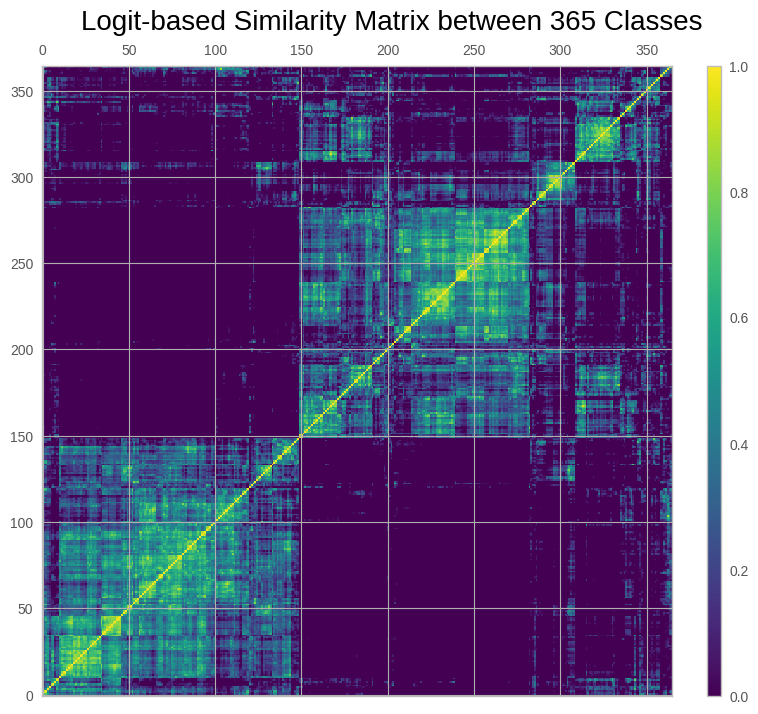

In [10]:
corr_mat_logits, indices_logits = reorder_matrix(corr_mat_logits)
show_matrix(corr_mat_logits, 'Logit-based Similarity Matrix between 365 Classes')


Let us probe some classes at dense locations. For simplicity we infer the locations from the static image of the matrix and pass the respective classes to the grid display. Interactive tools can make it easier to brush the matrix with the mouse to define a range and then to inspect thumbnails of its classes.

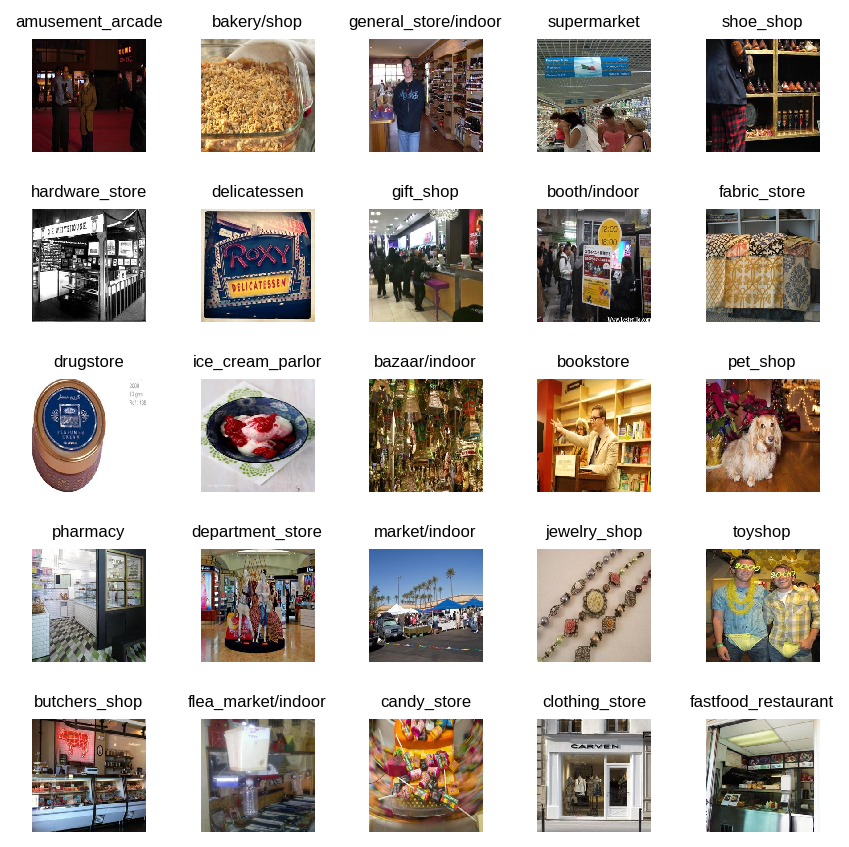

In [15]:
show_5x5_img_grid(indices_logits[10:35])

The above pictures corresopnd to mostly-indoor classes (where it happens the class `market/indoor` has an image that is taken outdoors, with other samples of this class being mostly taken indoors).

We select another range from the other big cluster of the matrix and show samples of the classes it encompasses below. They are all mostly-outdoor classes. 

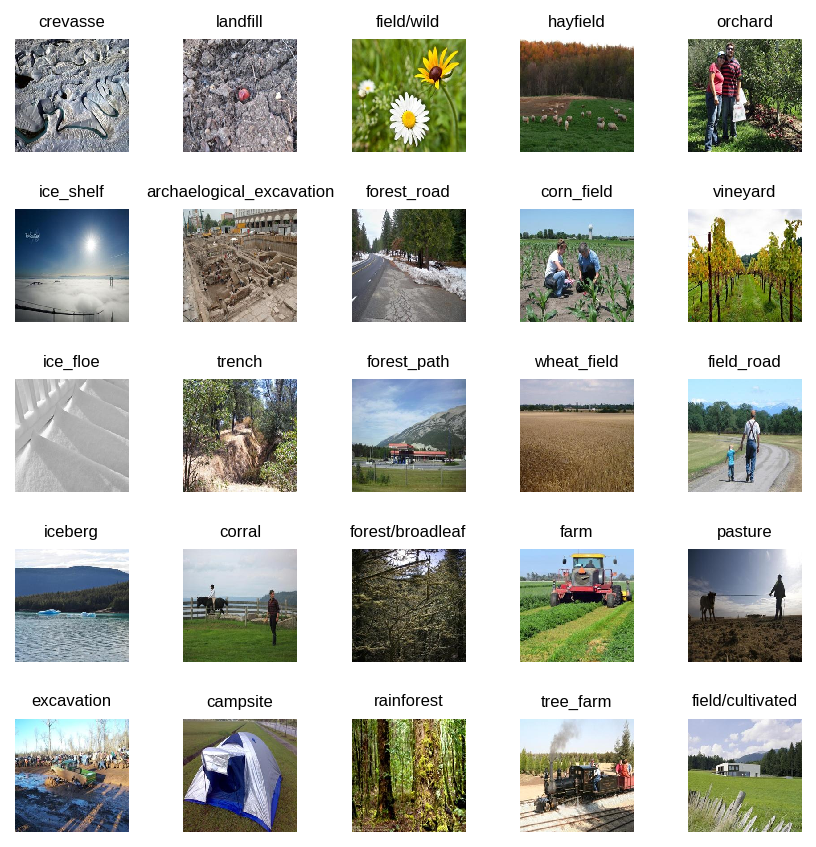

In [16]:
show_5x5_img_grid(indices_logits[210:235])


** This means the biggest distinctions between the classes based on the logits is whether they represent outdoor or indoor concepts. As we show towards the end of the notebook, most confusions are between classes that are either both indoors or both outdoors. **

Within each of the two broad groups, there are subgroups of similar concepts. For examples, within the indoor cluster,  shopping / office / home scenes form subclusters.

### 4- What about the Confusion Matrix?

Earlier work relied on a confusion matrix to analyze classification structure in ImageNet (http://vision.stanford.edu/pdf/DengBergLiFei-Fei_ECCV2010.pdf and  https://arxiv.org/abs/1710.06501). In both pieces of work, the matrix was ordered according to the WordNet hierarchy of the ImageNet classes.

We argued in our manuscripts than confusion matrices are short of being a generic means for visualizing the classification structure. We illustrae this on Places365. Let us reorder and visualize the confusion matrix instead of the logits-based similarity matrix:

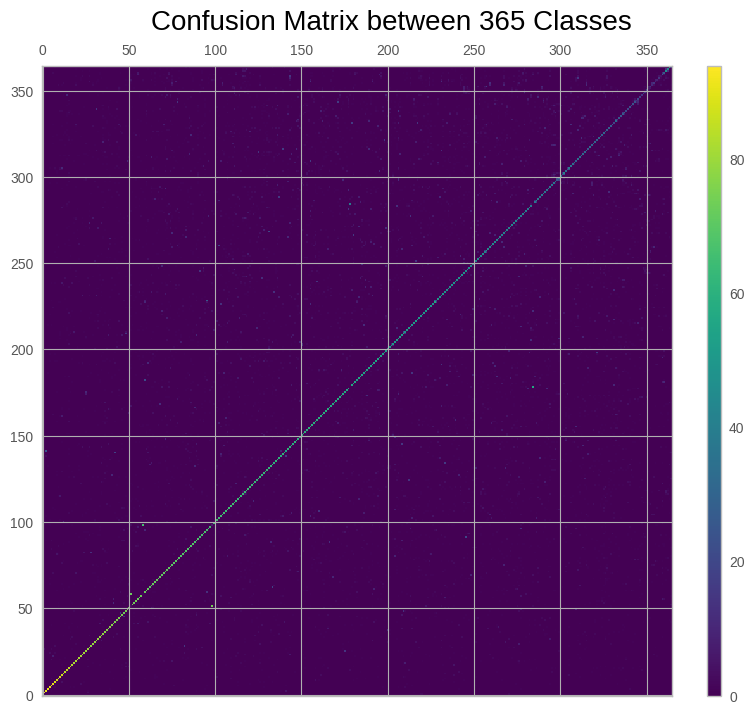

In [28]:
confmat_reordered, indices_confmat = reorder_matrix(confmat)
show_matrix(confmat_reordered, 'Confusion Matrix between 365 Classes')

Expectedly, the diagonal (representing correct classification) contains most of the values with the top-1 accuracy being > 54%. This both obscures what is left, and impacts the ordering algorithm. We can try to mitigate this by setting the values along the diagonal to 0 or to 1, or by using non-linear color mapping. 

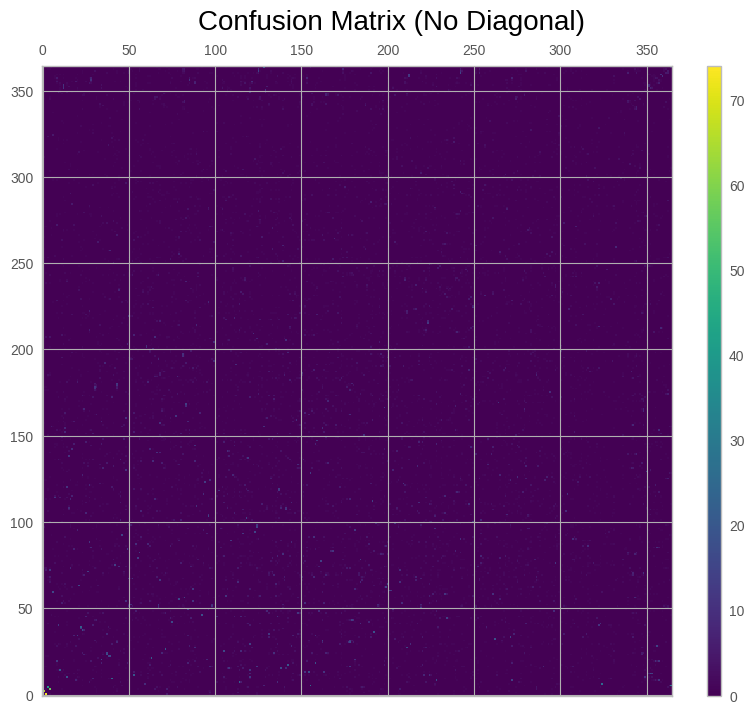

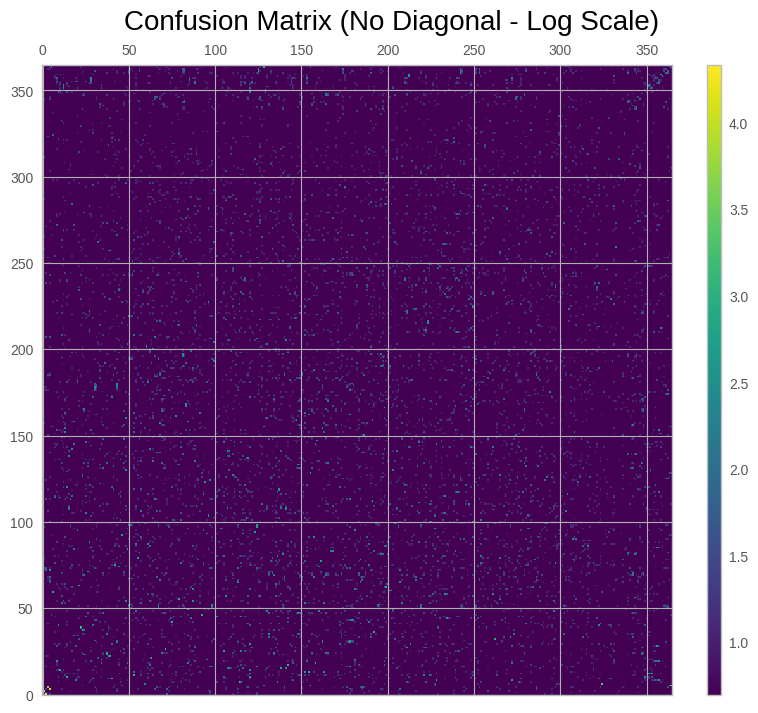

In [35]:
confmat_nodiag = confmat.copy()
for i in range(365):
    confmat_nodiag[i, i] = 0
confmat_nodiag, indices_confmat_nodiag = reorder_matrix(confmat_nodiag)
show_matrix(confmat_nodiag, 'Confusion Matrix (No Diagonal)')
show_matrix(np.log(confmat_nodiag + 2), 'Confusion Matrix (No Diagonal - Log Scale)')


None of this helps revealing a block pattern, which is the key to infer any latent class hierarchy. 

Instead, let us re-order the confusion matrix using the same order we found based on the logit-based similarities. This ordering is still stored in `indices_logits`, we can reuse it and plot the matrix. 

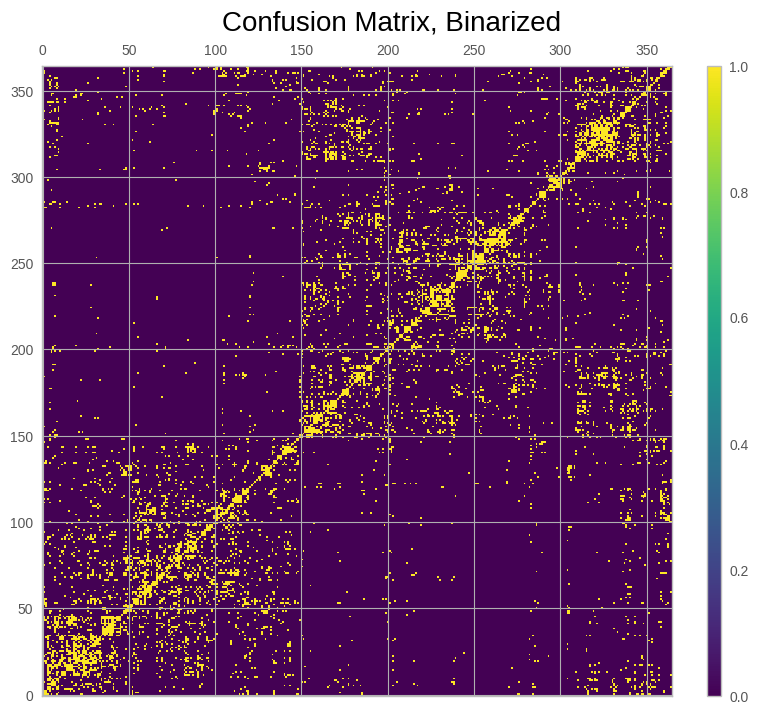

In [39]:
confmat_copy = confmat.copy()
confmat_copy = confmat_copy[indices_logits,:]
confmat_copy = confmat_copy[:,indices_logits]
show_matrix(confmat_copy, 'Confusion Matrix')
# show_matrix(np.log(confmat_copy + 2), 'Confusion Matrix (Log Scale)')
# show_matrix((confmat_copy > 0) * 1, 'Confusion Matrix, Binarized')


Coloring the cell values using a log color scale or a binary scale (zero vs. non-zero cell) helps us see the block pattern. It is evident that the two ranges [0, 150] and [150, 300] correspond to two groups of classes that are rarely confused for each other. These groups represent indoor and outdoor scenes.  